### Exploration
Exploratory analysis of the two h5ad files generated in XYZeq.

In [33]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings

import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [34]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

In [35]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [36]:
path = '/myvol/data2/10x/20191102/'

In [37]:
exps = dict()
for exp in range(1,3):
    exps[exp] = dict()

In [38]:
for exp in exps:
    exps[exp]['path'] = path + 'Liver%s_raw_feature_bc_matrix.h5' % exp

In [39]:
exps

{1: {'path': '/myvol/data2/10x/20191102/Liver1_raw_feature_bc_matrix.h5'},
 2: {'path': '/myvol/data2/10x/20191102/Liver2_raw_feature_bc_matrix.h5'}}

In [40]:
for exp in exps:
    warnings.filterwarnings('ignore')
    exps[exp]['adata'] = sc.read_10x_h5(exps[exp]['path'], genome='mm10')
    sc.utils.view_to_actual(exps[exp]['adata'])
    exps[exp]['adata'].var_names_make_unique()
    warnings.filterwarnings('default')

reading /myvol/data2/10x/20191102/Liver1_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /myvol/data2/10x/20191102/Liver2_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:08)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


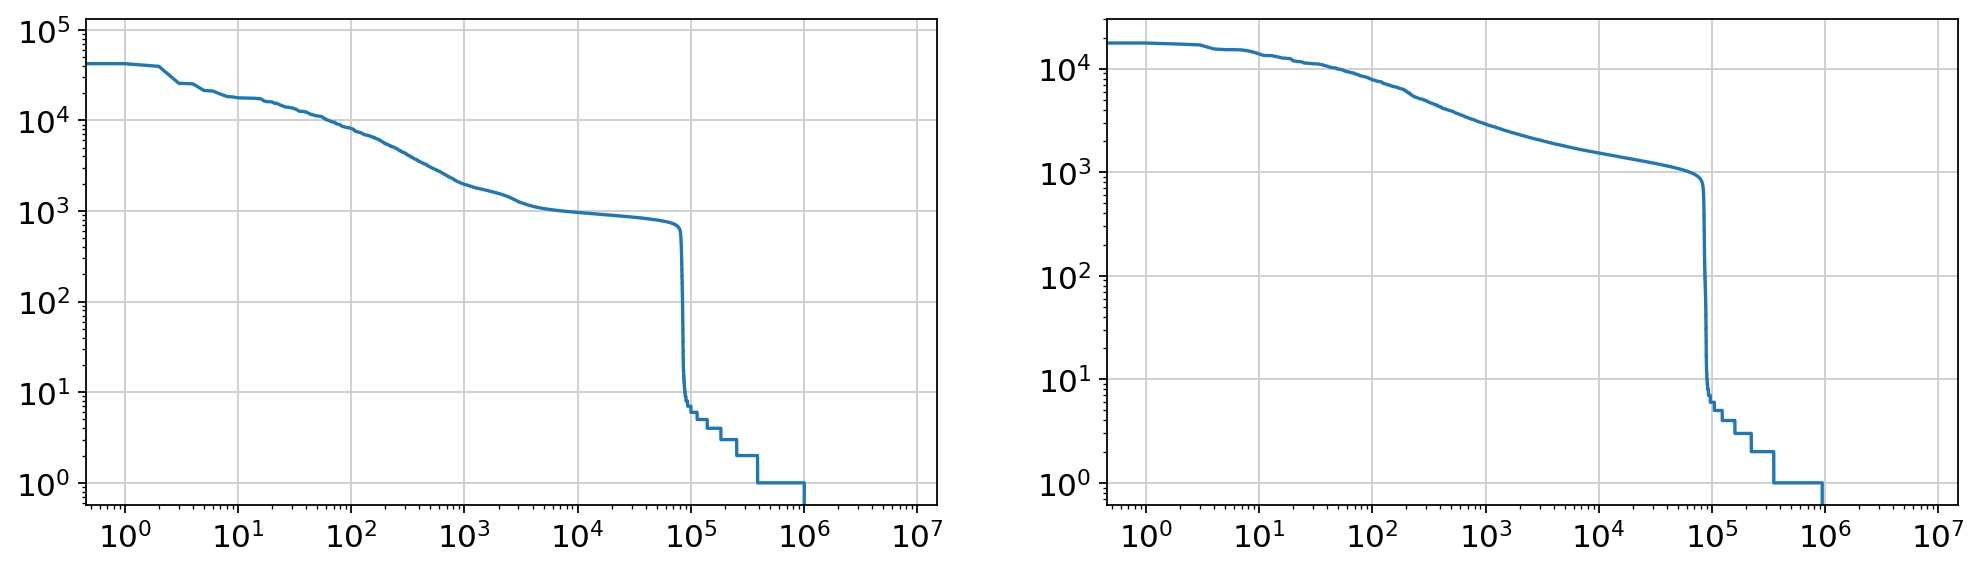

In [41]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
for exp, ax in zip(exps, np.ravel(axes)):
    ax.plot(np.sort(np.ravel(exps[exp]['adata'].X.sum(1)))[::-1])
    ax.set_xscale('log')
    ax.set_yscale('log')

In [42]:
cells = [2500, 2500]

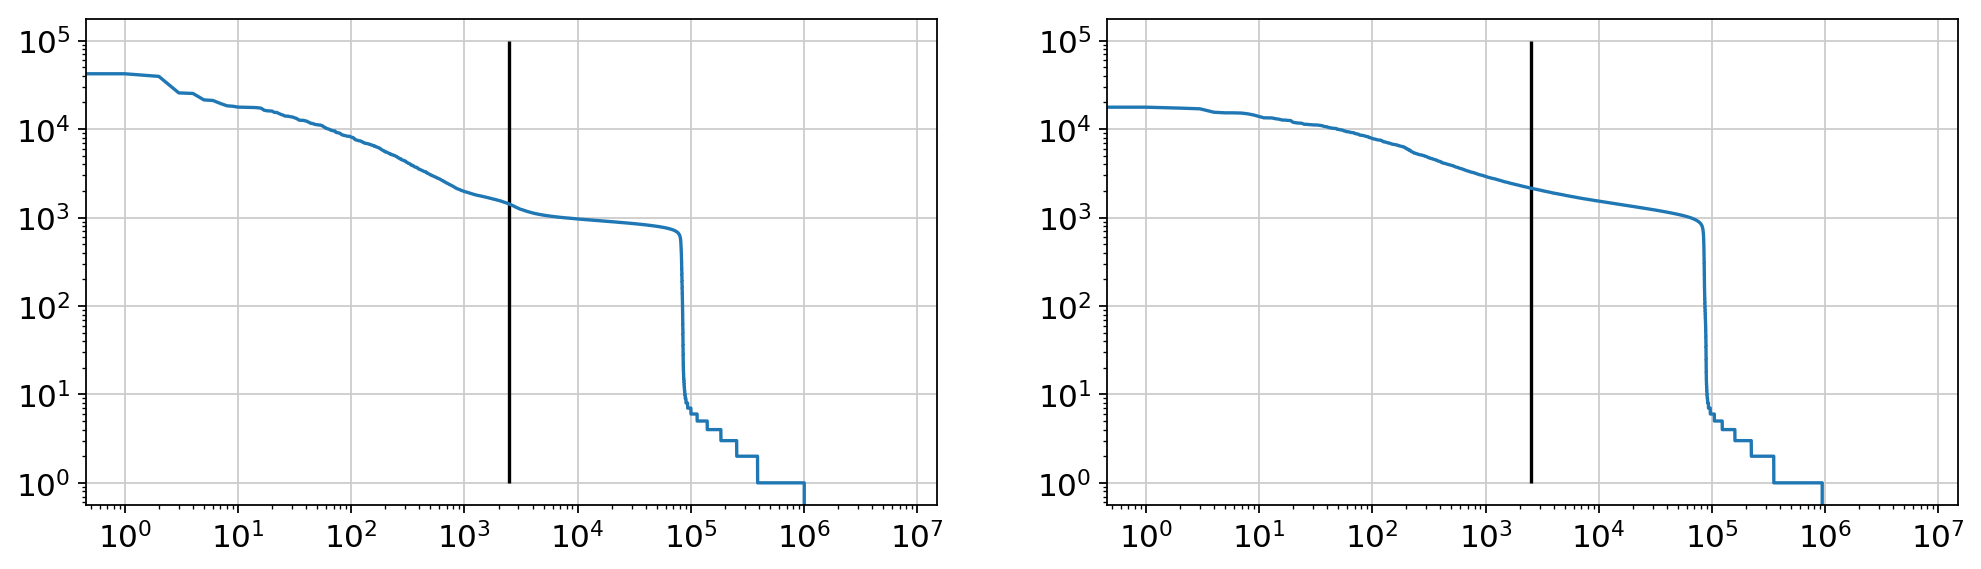

In [43]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
for exp, ax, cell in zip(exps, np.ravel(axes), cells):
    ax.plot(np.sort(np.ravel(exps[exp]['adata'].X.sum(1)))[::-1])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.vlines(cell,1,1e5);

In [58]:
for exp in exps:
    obs = exps[exp]['adata'].obs.copy()
    obs['n_counts'] = np.ravel(exps[exp]['adata'].X.sum(1))
    exps[exp]['obs_n_counts'] = obs

for exp, cell in zip(exps, cells):
    exps[exp]['cell_number'] = cell

for exp in exps: # I APOLOGIZE FOR THIS STUPID NEXT LINE
    exps[exp]['adata'] = exps[exp]['adata'][exps[exp]['obs_n_counts'].sort_values('n_counts', ascending=False)[:exps[exp]['cell_number']].index.values,:].copy()

for exp in exps:
    genelist = exps[exp]['adata'].var_names.tolist()
    
    exps[exp]['mito_genes_names'] = [gn for gn in genelist if gn.startswith('mt-')]
    exps[exp]['mito_genes'] = [genelist.index(gn) for gn in exps[exp]['mito_genes_names']]

    exps[exp]['ribo_genes_names'] = [gn for gn in genelist if gn.startswith('Rps') or gn.startswith('Rpl')]
    exps[exp]['ribo_genes'] = [genelist.index(gn) for gn in exps[exp]['ribo_genes_names']]

Store percent mito and percent ribo in each sample:

for exp in exps:
    exps[exp]['adata'].obs['percent_mito'] = np.ravel(np.sum(exps[exp]['adata'][:, exps[exp]['mito_genes']].X, axis=1)) / np.ravel(np.sum(exps[exp]['adata'].X, axis=1))
    exps[exp]['adata'].obs['percent_ribo'] = np.ravel(np.sum(exps[exp]['adata'][:, exps[exp]['ribo_genes']].X, axis=1)) / np.ravel(np.sum(exps[exp]['adata'].X, axis=1))

fig, axes = plt.subplots(1,2,figsize=(20,3))
for exp, ax in zip(exps,np.ravel(axes)):
    ax.hist(exps[exp]['adata'].obs['percent_mito'].values,bins=200,density=True)
    ax.set_title(exp)

thresholds = [0.1, 0.2]

for exp, thresh in zip(exps, thresholds):
    exps[exp]['adata'] = exps[exp]['adata'][exps[exp]['adata'].obs['percent_mito'] < thresh].copy()

def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 500),color='gray') # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

fig, axes = plt.subplots(1,2,figsize=(15,4))
for exp, ax in zip(exps,axes):
    vals = sc.pp.filter_genes(exps[exp]['adata'], min_counts=0, inplace=False)[1] # total number of UMIs observed
    my_plot(ax, vals)
plt.tight_layout()

min_counts = [50, 50]

for exp, min_count in zip(exps,min_counts):
    sc.pp.filter_genes(exps[exp]['adata'], min_counts=min_count, inplace=True)
#     sc.pp.filter_genes(exps[exp]['adata'], max_counts=4e4, inplace=True)

In [59]:
for exp in exps:
    sc.pp.log1p(exps[exp]['adata'])
    sc.pp.normalize_per_cell(exps[exp]['adata'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Highly Variable Genes Extraction

In [60]:
def hv_run(adata,min_mean=0.0125, min_disp=0.5, max_mean=3):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='cell_ranger',inplace=True, 
                                min_mean=min_mean, 
                                min_disp=min_disp, 
                                max_mean=max_mean,
                                n_bins=500)
    return hv_adata

def hv_plot(hv_adata, gate=None, highlight_genes=None):
    plt.figure(figsize=(7,7))
    plt.minorticks_on()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True,which='both',axis='both')
    plt.plot(hv_adata.var['means'].values,hv_adata.var['dispersions_norm'].values,linewidth=0, marker='.',markersize=0.5, color='b');
    if type(highlight_genes) != type(None):
        mask = [i in highlight_genes for i in hv_adata.var_names]
        highlight_means = hv_adata.var['means'].values[mask]
        highlight_disps = hv_adata.var['dispersions_norm'].values[mask]
        plt.plot(highlight_means,highlight_disps,linewidth=0, marker='o',markersize=10, color='r', mfc='none');
    ax = plt.gca()
    if type(gate) != type(None):
        gatepatch = patches.Polygon(gate,linewidth=1,edgecolor='teal',facecolor='turquoise',alpha=0.5)
        ax.add_patch(gatepatch);

def hv_genes(hv_adata, gate, adata=None):
    '''
    Receive boolean for genes in gate or new subsetted adata object, if provided.
    '''
    genes = list()
    means = hv_adata.var['means'].values
    disps = hv_adata.var['dispersions_norm'].values
    pointsmap = map(Point,means,disps)
    polygon = Polygon(gate)
    for i in pointsmap:
        genes.append(polygon.contains(i))
    if type(adata) != type(None):
        adata = adata[:,genes].copy()
        return adata
    else:
        return genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


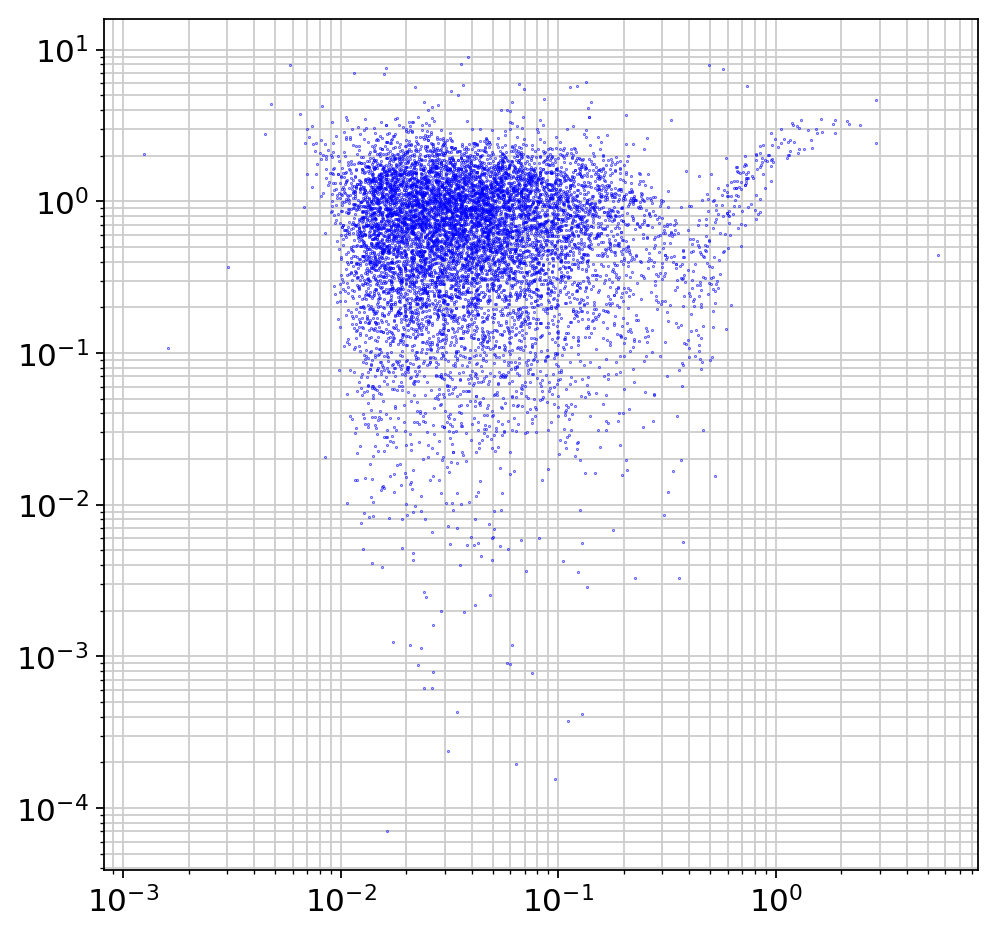

In [62]:
for exp in [1]:
    hv_adata = hv_run(exps[exp]['adata'])
    hv_plot(hv_adata)

Don't subset at this time.

### Scaling and Dim Reduction  

In [63]:
for exp in exps:
    sc.pp.scale(exps[exp]['adata'], max_value=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:01)


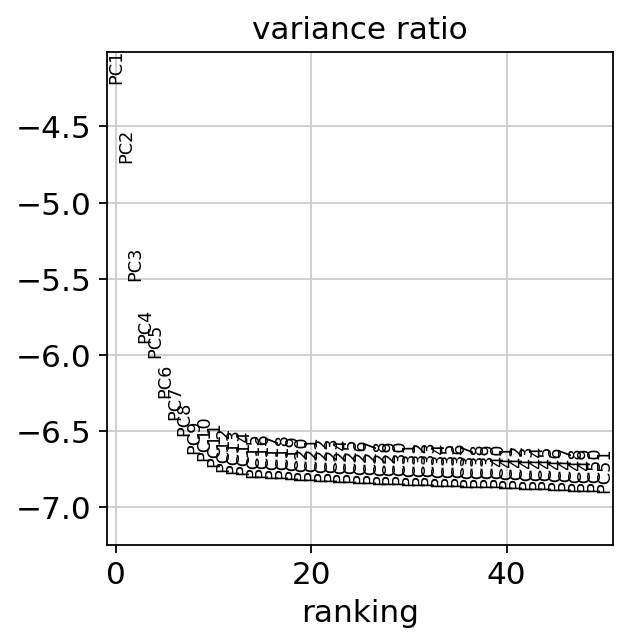

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:01)


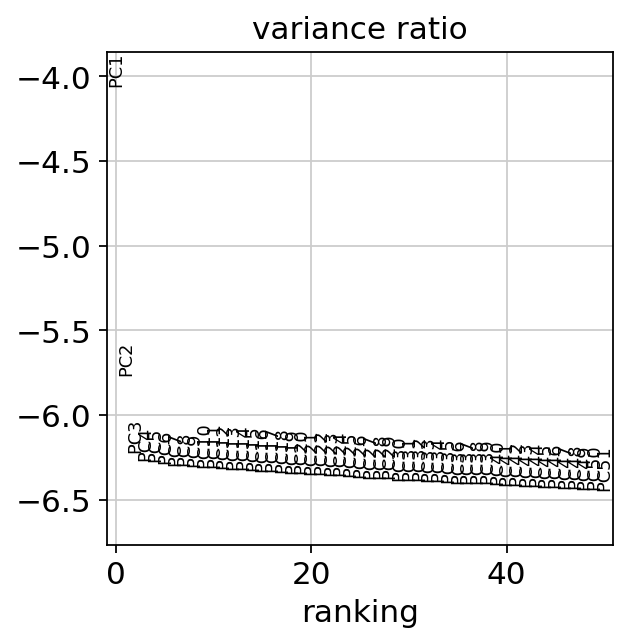

In [65]:
for exp in exps:
    warnings.filterwarnings('ignore')
    sc.pp.pca(exps[exp]['adata'],n_comps=100)
    sc.pl.pca_variance_ratio(exps[exp]['adata'],log=True, n_pcs=50)
    warnings.filterwarnings('default')

### Visualization

In [66]:
n_pcs = [15, 7]

In [67]:
for exp, n_pc in zip(exps, n_pcs):
    warnings.filterwarnings('ignore')
    sc.pp.neighbors(exps[exp]['adata'],n_neighbors=15,n_pcs=n_pc) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
    warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [68]:
for exp in exps:
    sc.tl.umap(exps[exp]['adata'])#, min_dist=.05, spread=5, alpha=2)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [69]:
resolutions = [0.6, 0.15]
for exp, res in zip(exps, resolutions):
    sc.tl.leiden(exps[exp]['adata'],resolution=res)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


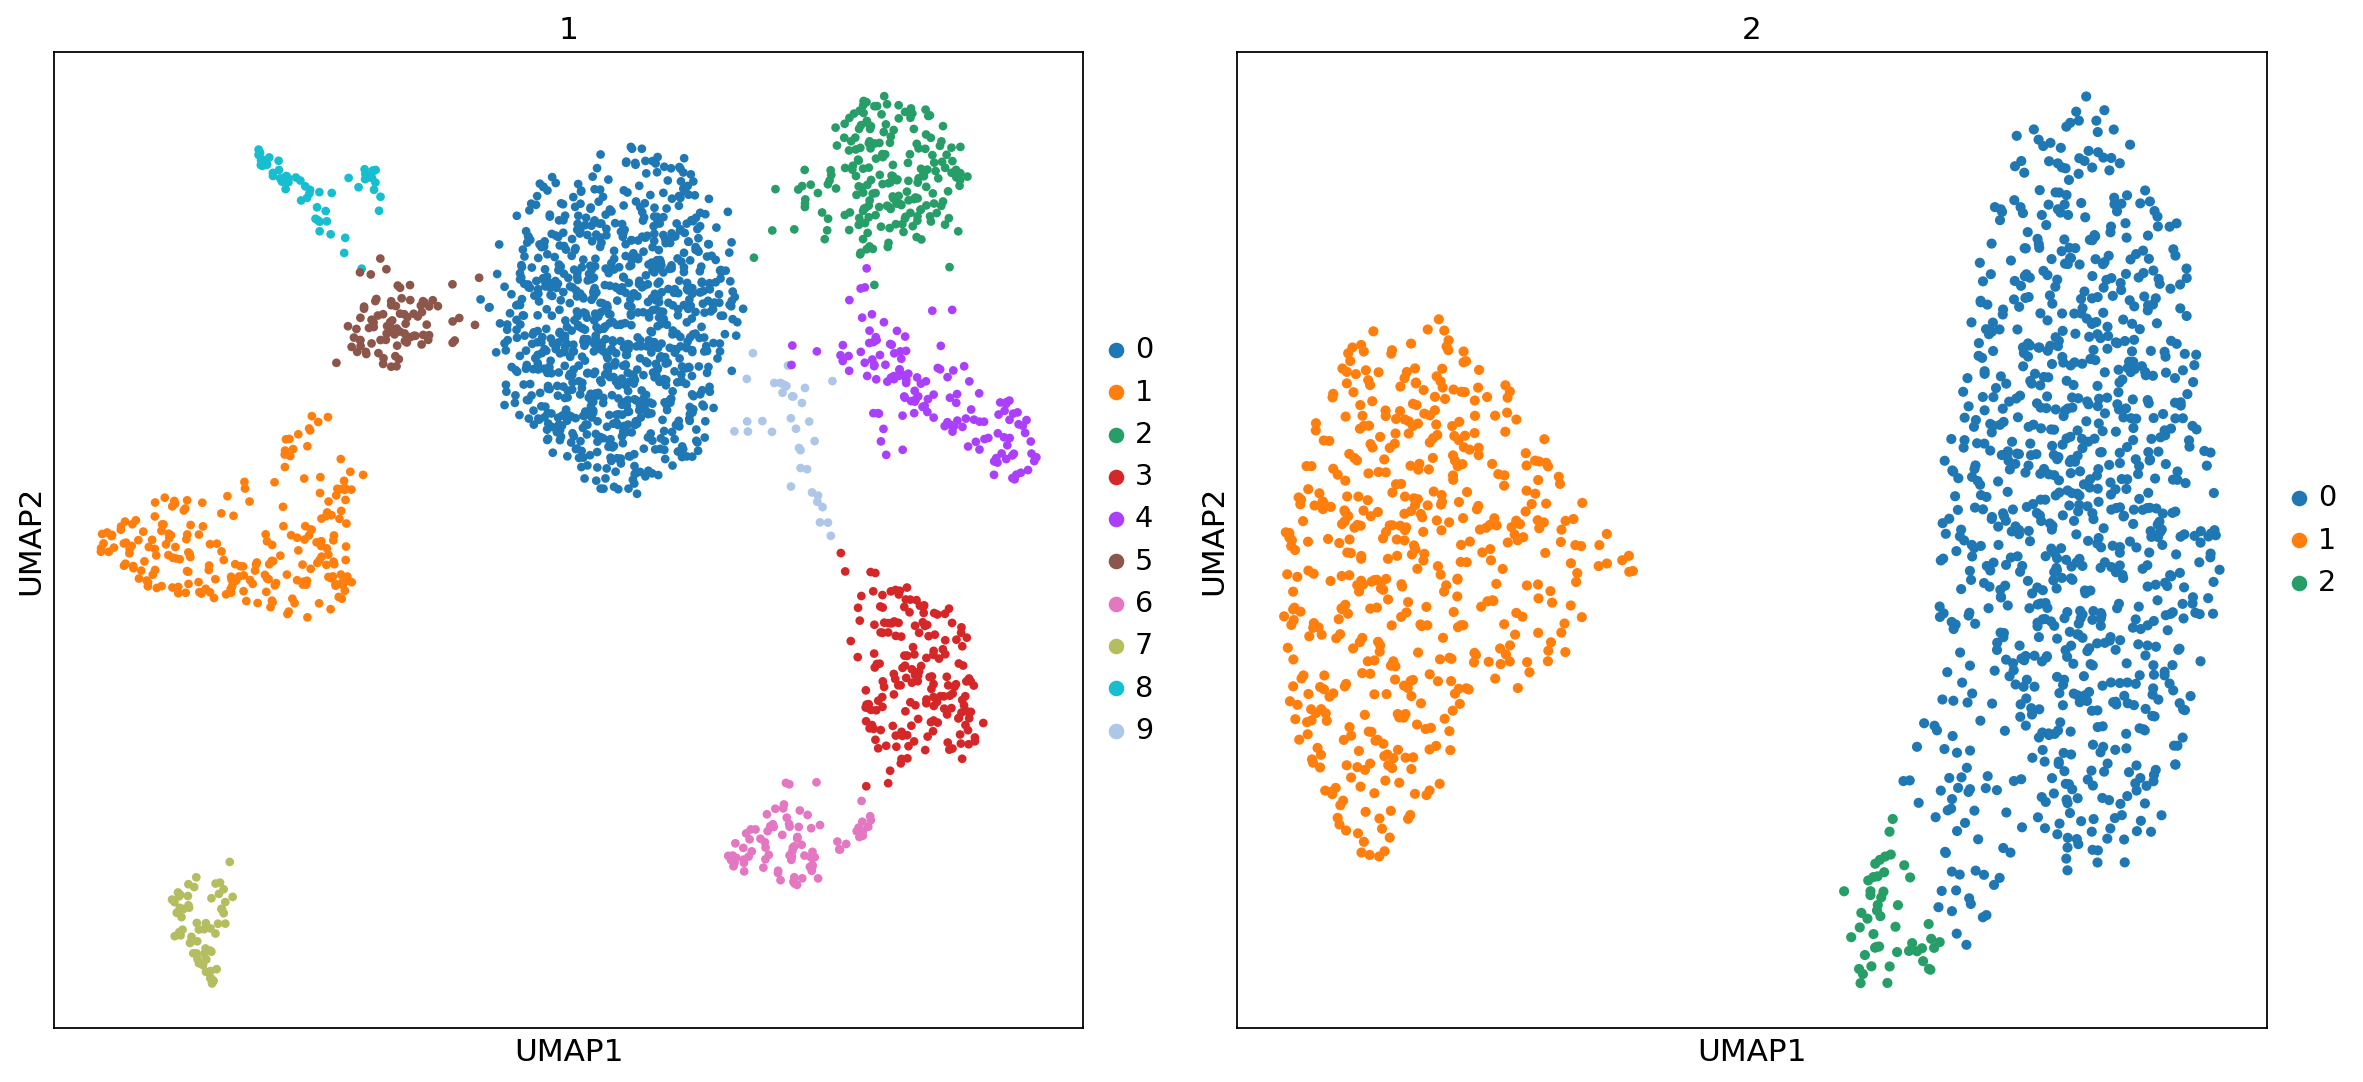

In [70]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
for exp, ax in zip(exps, np.ravel(axes)):
    sc.pl.umap(exps[exp]['adata'],color='leiden',ax=ax, return_fig=False, show=False, title=str(exp))
plt.tight_layout()

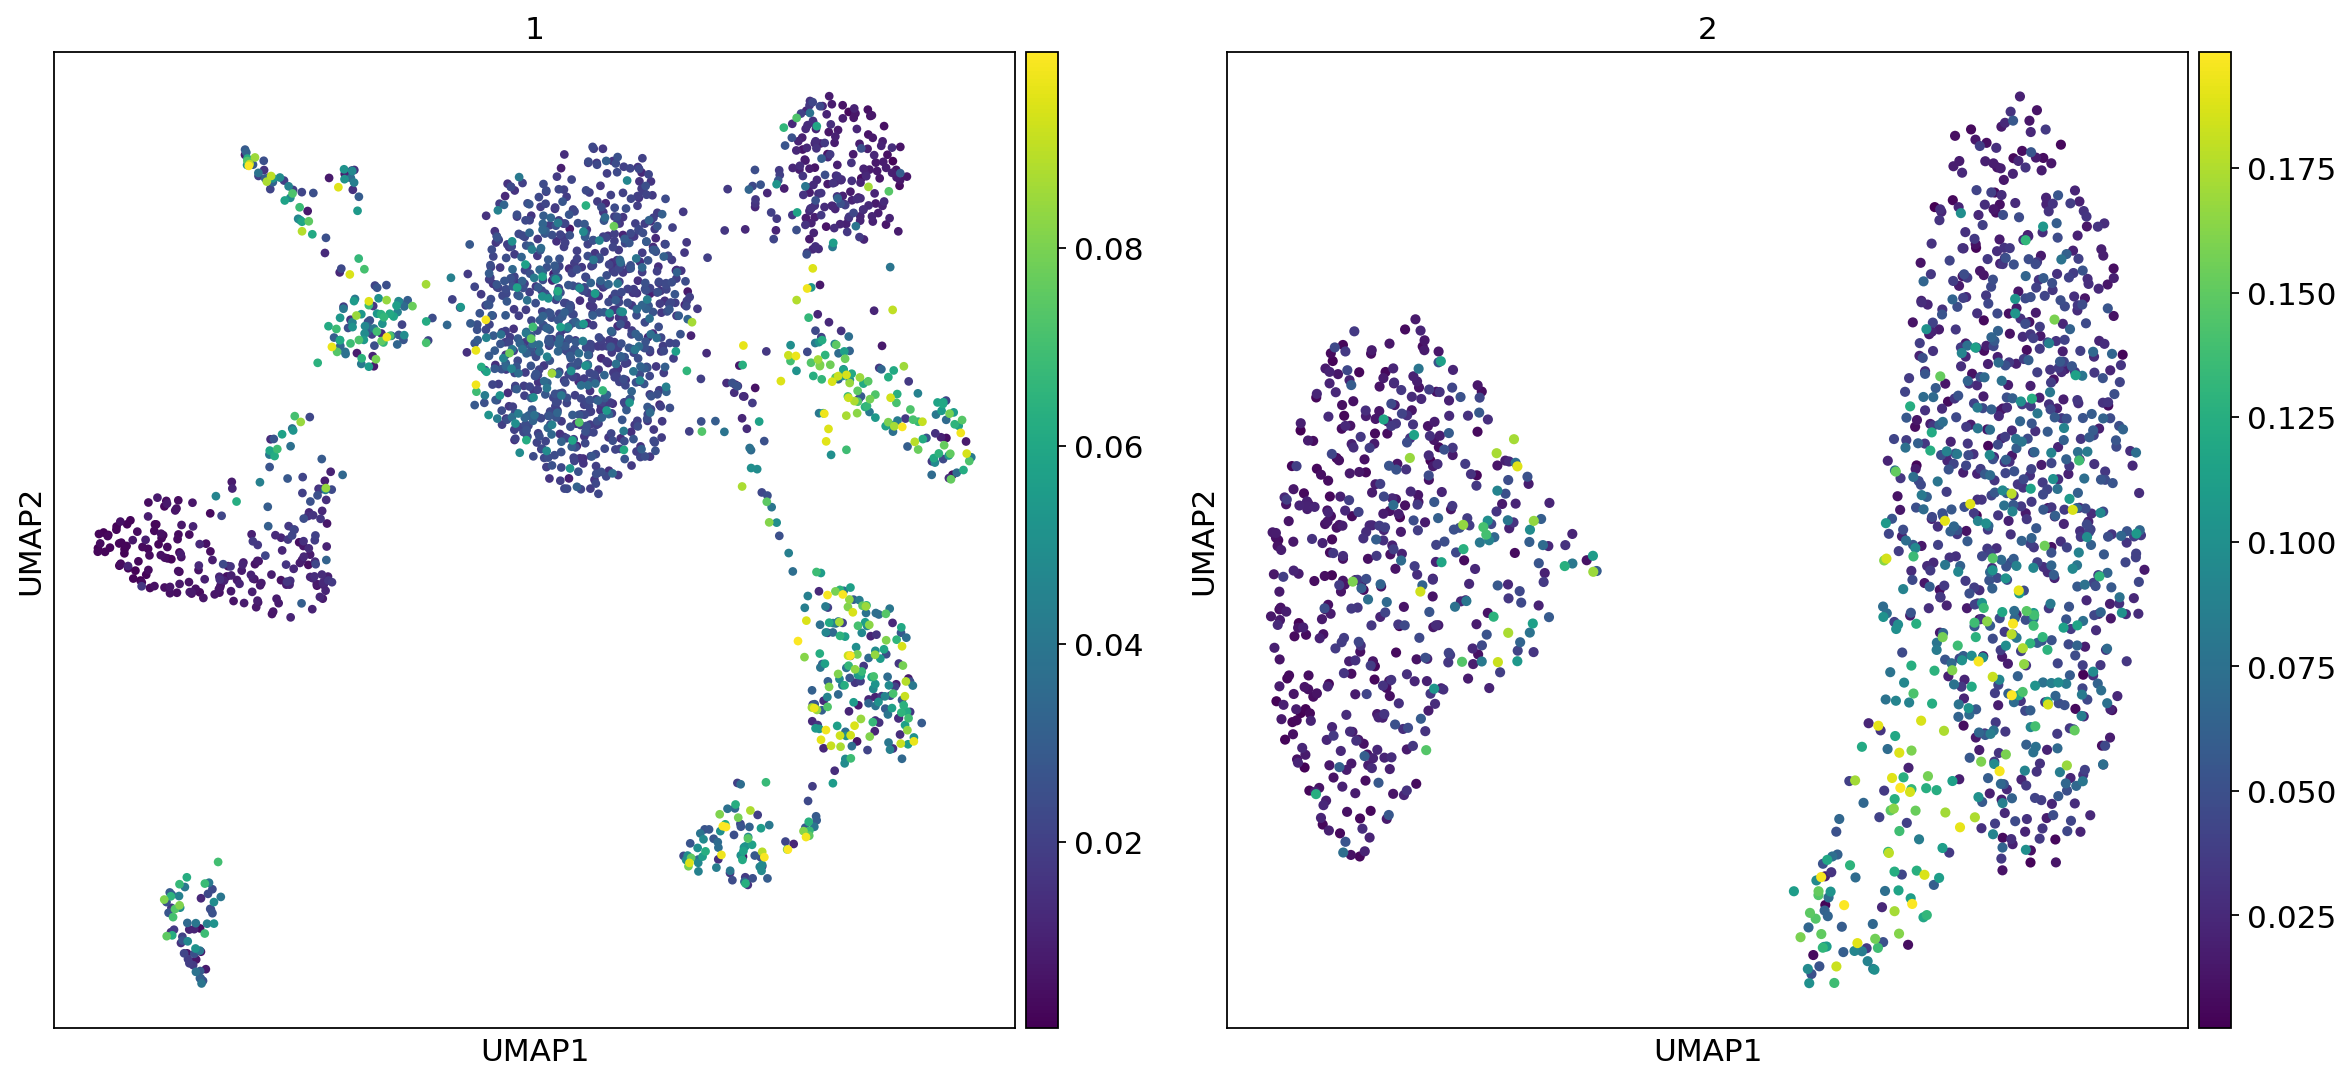

In [71]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
for exp, ax in zip(exps, np.ravel(axes)):
    sc.pl.umap(exps[exp]['adata'],color='percent_mito',ax=ax, return_fig=False, show=False, title=str(exp))
plt.tight_layout()

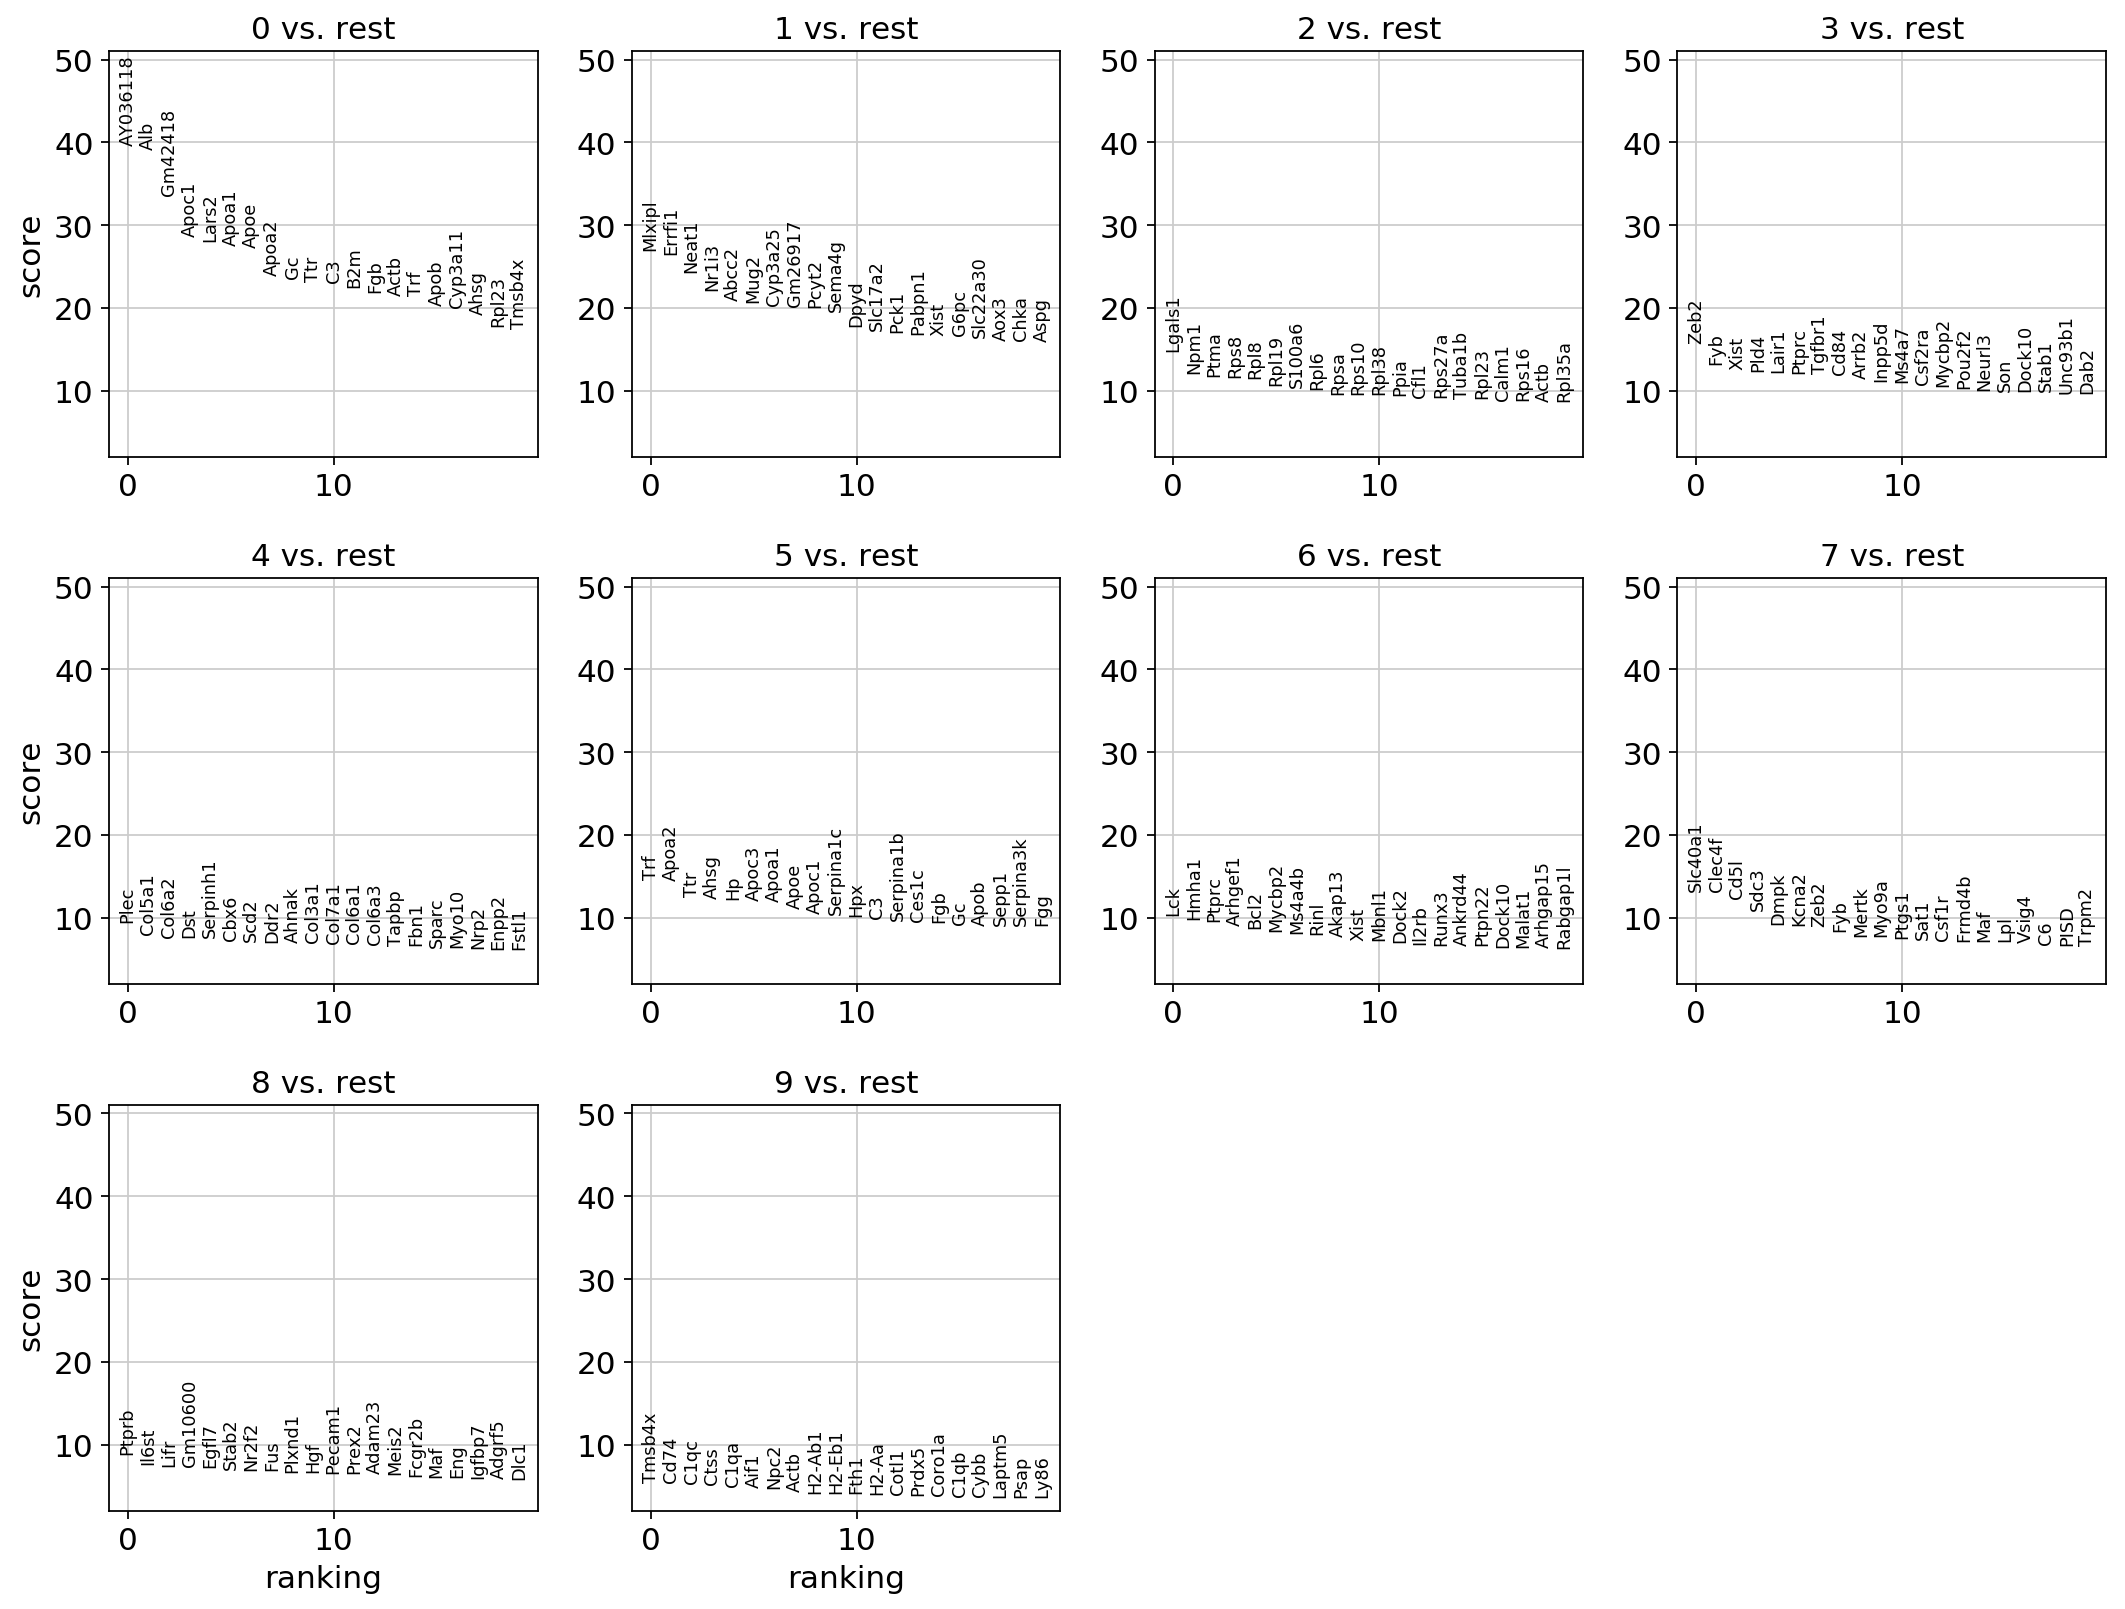

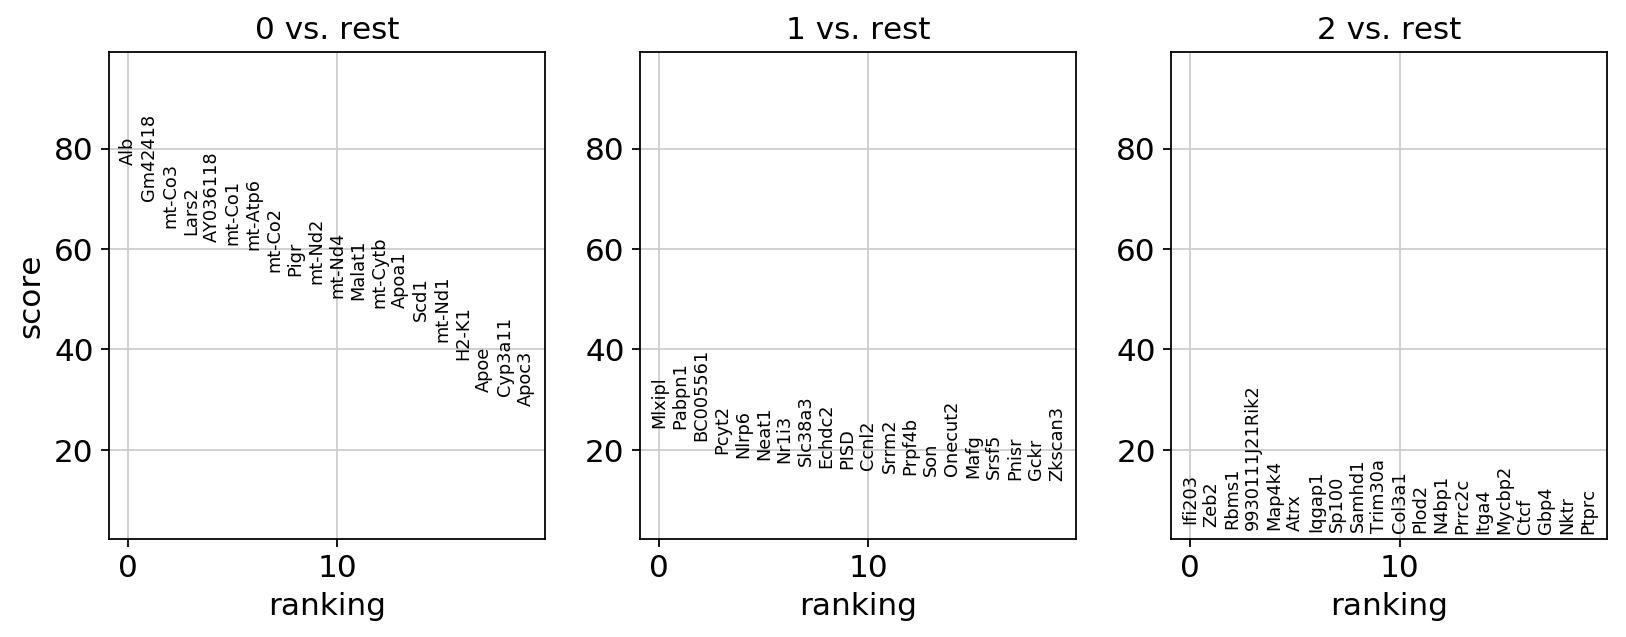

In [72]:
sc.settings.verbosity = 0
for exp in exps:
    warnings.filterwarnings('ignore')
    sc.tl.rank_genes_groups(exps[exp]['adata'],groupby='leiden')
    warnings.filterwarnings('default')
    sc.pl.rank_genes_groups(exps[exp]['adata'])
sc.settings.verbosity = 3

Okay, Liver1 looks promising. Going to only move forward with that.


In [74]:
with open('/myvol/data2/10x/20191102/liver1.pkl','wb') as file:
    pkl.dump(exps[1],file)